In [1]:
import scipy.stats as sps
from scipy.interpolate import interp1d
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from CMF_Predictor import CMFRecommender

from libmf import mf

Using file found in /home/koltastic/MIPT/m1p/2024-Project-144/.venv/lib/python3.11/site-packages:
/home/koltastic/MIPT/m1p/2024-Project-144/.venv/lib/python3.11/site-packages/libmf.cpython-311-x86_64-linux-gnu.so


In [2]:
def usefulness(c, w, noice):
    return np.arctan(c - w + noice) / np.pi + 0.5

In [3]:
customer_distribution = sps.norm(0.6, 0.2)
w_distribution = sps.norm(0, 0.4)

epsilon = sps.norm(0, 0.05)

class Distribution_Handler:
    def __init__(self, distribution):
        self.distribution = distribution
        
    def rvs(self, size=1):
        if issubclass(type(self.distribution), sps.rv_continuous):
            return self.distribution.rvs(size)
        else:
            return self.distribution.resample(size)[0]
        

In [4]:
def interpol_distribution(sample):
    hst = np.histogram(sample, density=True, bins=200)
    return interp1d(hst[1][:-1], hst[0], kind='linear',
                               fill_value=0.0, bounds_error=False)

In [5]:
def zero_step(model: CMFRecommender, user_info, item_info, topn=52):
    new_feedback = []

    maximal_user, maximal_item = model.get_max_index()
    old_users = model.get_known_users_info().set_index("UserId")
    
    for i in range(topn):
        user_id = np.random.choice(round(maximal_user) - 1)
        for index, item_row in item_info.iterrows():
            deal = sps.bernoulli.rvs(usefulness(old_users.loc[user_id]["F"], item_row["F"], epsilon.rvs()))  # моделируем сделки
            new_feedback.append((user_id, item_row["ItemId"], deal))
    
    for index, user_row in user_info.iterrows():
        w_offered = model.recommend_items_cold(user_row["F"], topn)["ItemId"]
        for w in w_offered:
            deal = sps.bernoulli.rvs(usefulness(user_row["F"], w, epsilon.rvs()))  # моделируем сделки
            new_feedback.append((user_row["UserId"], w, deal))
    
    model.retrain(new_feedback, user_info, item_info)
    return model


In [23]:
def print_distributions(user_info, item_info):
    fig, axs = plt.subplots(ncols=2)
    sns.kdeplot(user_info["F"],ax=axs[0])
    axs[0].set_title("User Distribution")
    sns.kdeplot(data=item_info["F"], ax=axs[1])
    axs[1].set_title("Item Distribution")

In [24]:
def dynamic_system_iterate(model: CMFRecommender, customer_distribution, w_distribution, c_size=10, w_size=10, num_of_steps=5,
                           topn=5, delta=0.00001, visualize_distributions=False):
    
    maximal_user, maximal_item = model.get_max_index()
    user_info = pd.DataFrame({"F": customer_distribution.rvs(size=c_size)})  # size = (c_size, c_feature_size) в многомерном случае 
    user_info["UserId"] = np.arange(maximal_user + 1, maximal_user + 1  + c_size)

    item_info = pd.DataFrame({"F": w_distribution.rvs(size=w_size)})  # size = (w_size, w_feature_size) в многомерном случае 
    item_info["ItemId"] = np.arange(maximal_item + 1, maximal_item + 1 + w_size)
    model = zero_step(model, user_info, item_info, topn=topn)
    
    if visualize_distributions:
        print_distributions(user_info, item_info)
    
    new_feedback = []
    
    for step in range(1, num_of_steps + 1):
        for index, user_row in user_info.iterrows():
            w_offered = model.recommend_items(user_row["UserId"], item_info['ItemId'], topn=topn, exclude_rated=True)["ItemId"]
            for w in w_offered:
                deal = sps.bernoulli.rvs(usefulness(user_row["F"], w, epsilon.rvs()))  # моделируем сделки
                new_feedback.append((user_row["UserId"], w, deal))
        model.retrain(new_feedback, [], [])
    
    
    # смена распределения
    new_feedback_df = pd.DataFrame(new_feedback, columns=['UserId', 'ItemId', 'Feedback'])
    new_feedback_df["Feedback"] += delta
    grouped_users = new_feedback_df.groupby('UserId')['Feedback'].mean().reset_index()
    
    user_info = user_info.merge(grouped_users, how="inner", on='UserId')
    
    customer_distribution = Distribution_Handler(sps.gaussian_kde(user_info["F"], weights=user_info['Feedback']))
    grouped_items = new_feedback_df.groupby('ItemId')['Feedback'].mean().reset_index()
    # grouped_items['Feedback'] += delta
        
    item_info = item_info.merge(grouped_items, how="inner", on='ItemId')

    w_distribution = Distribution_Handler(sps.gaussian_kde(item_info["F"], weights=item_info['Feedback']))

    return customer_distribution, w_distribution, new_feedback



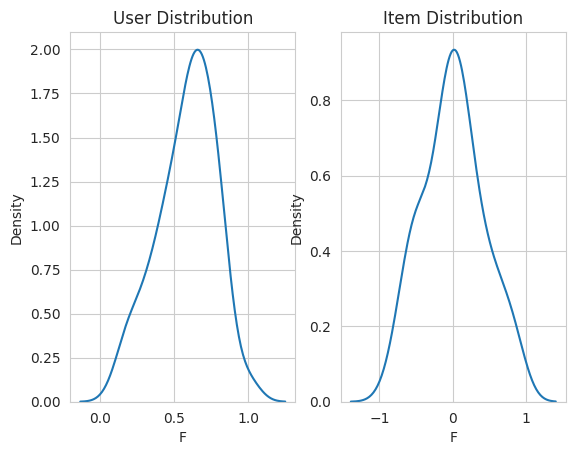

In [25]:
user_info = pd.DataFrame({"F": customer_distribution.rvs(size=100)}) # генерим датасет для нулевой итерации
user_info["UserId"] = np.arange(100)

item_info = pd.DataFrame({"F": w_distribution.rvs(size=100)})
item_info["ItemId"] = np.arange(100)
feedback = []

print_distributions(user_info, item_info)

for i, user_row in user_info.iterrows():
    for j, item_row in item_info.iterrows():
        deal = sps.bernoulli.rvs(usefulness(user_row["F"], item_row["F"], epsilon.rvs()))
        feedback.append((user_row["UserId"], item_row["ItemId"], deal))


In [26]:
model = CMFRecommender(capacity=100000)
model.fit(feedback, user_info, item_info)

In [27]:
new_cust_distr, new_w_distr = customer_distribution, w_distribution

In [28]:
# new_cust_distr, new_w_distr, _ = dynamic_system_iterate(model, new_cust_distr, new_w_distr, c_size=10, w_size=10, visualize_distributions=True)

0
       UserId  ItemId  Rating
0         0.0     0.0       1
1         0.0     1.0       1
2         0.0     2.0       0
3         0.0     3.0       0
4         0.0     4.0       0
...       ...     ...     ...
10495   149.0    97.0       0
10496   149.0    55.0       0
10497   149.0     8.0       0
10498   149.0    86.0       0
10499   149.0    21.0       0

[10500 rows x 3 columns]
           F  UserId
0   0.703881     0.0
1   0.724444     1.0
2   0.745840     2.0
3   0.164562     3.0
4   0.615482     4.0
..       ...     ...
45  0.425559   145.0
46  0.139718   146.0
47  0.565731   147.0
48  0.317650   148.0
49  0.905852   149.0

[150 rows x 2 columns]
           F  ItemId
0  -0.125652     0.0
1  -0.093692     1.0
2   0.134671     2.0
3  -0.066682     3.0
4  -0.540917     4.0
..       ...     ...
45  0.138625   145.0
46  0.424620   146.0
47  0.104983   147.0
48  0.460202   148.0
49 -0.172509   149.0

[150 rows x 2 columns]
       UserId  ItemId  Rating
0         0.0     0.0       1


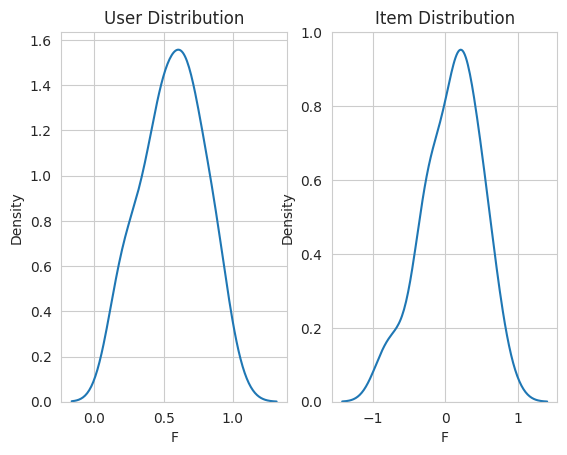

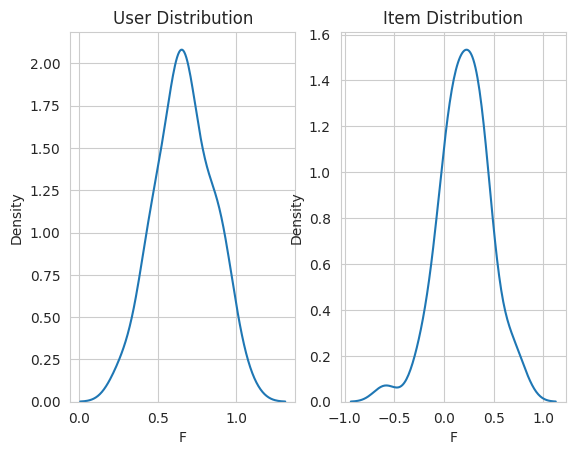

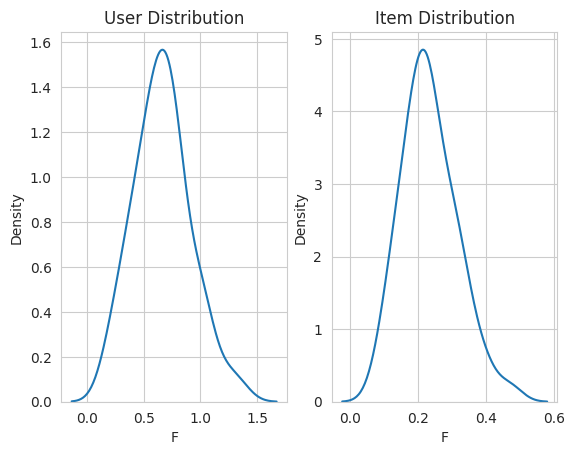

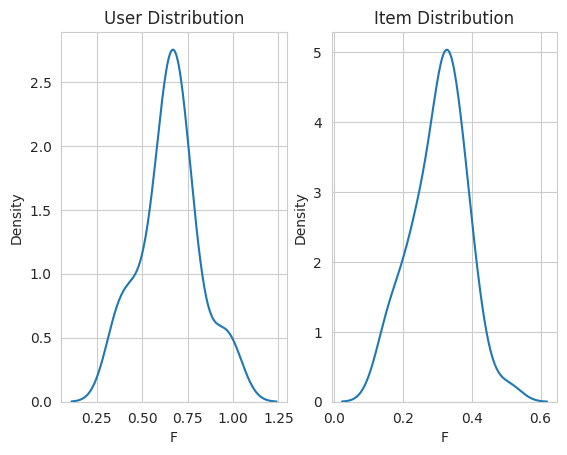

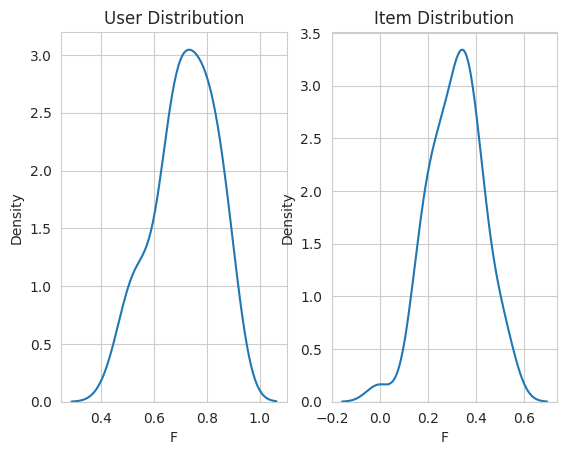

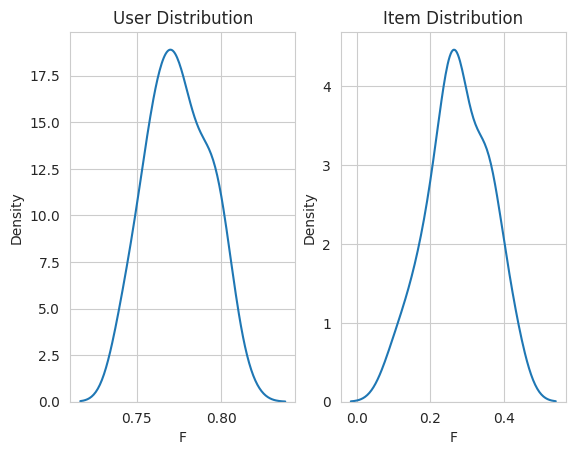

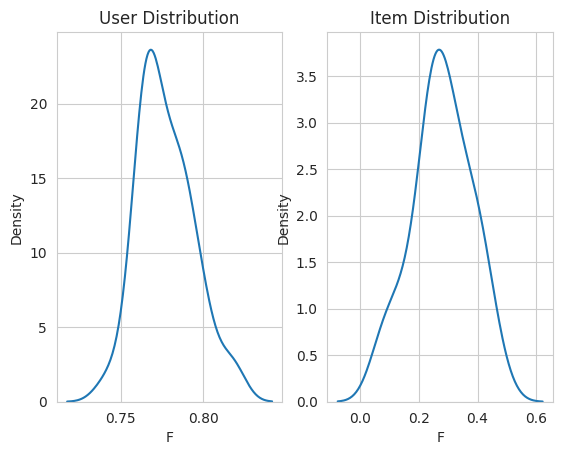

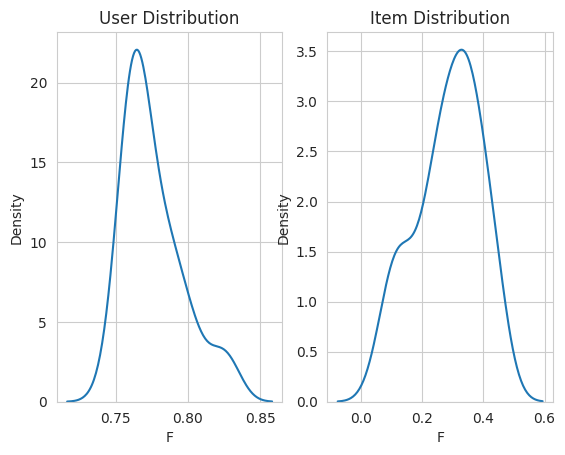

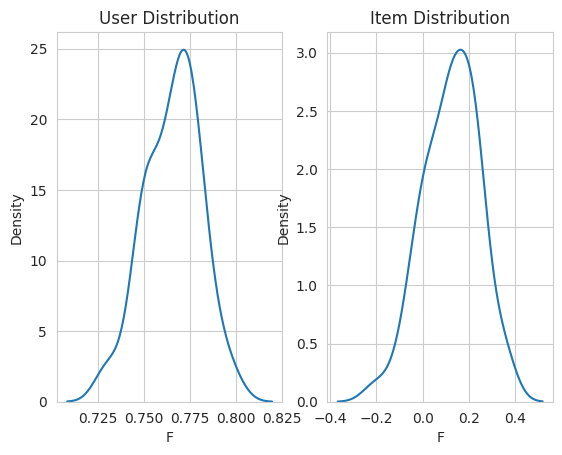

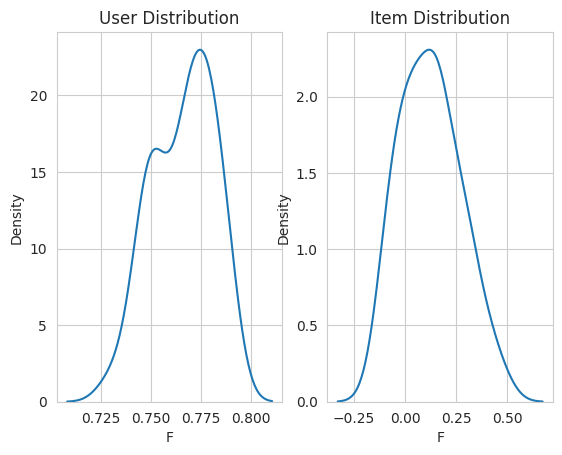

In [29]:
big_steps = 10
for i in range(big_steps):
    print(i)
    new_cust_distr, new_w_distr, _ = dynamic_system_iterate(model, new_cust_distr, new_w_distr, c_size=50, w_size=50, visualize_distributions=True)